## Expert Knowledge Worker

In [3]:
# imports
import os
import glob
from dotenv import load_dotenv
import gradio as gr

In [4]:
# imports for langchain
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_openai import OpenAIEmbeddings, ChatOpenAI

# from langchain_chroma import Chroma
from langchain.vectorstores import FAISS
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from langchain.memory import ConversationBufferMemory  
from langchain.chains import ConversationalRetrievalChain

In [5]:
# price is a factor for our company, so we're going to use a low cost model
MODEL = "gpt-4o-mini"
db_name = "vector_db"

In [6]:
# Load environment variables in a file called .env

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')

In [8]:
# Read in documents using LangChain's loaders
# Take everything in all the sub-folders of our knowledgebase

folders = glob.glob("knowledge-base/*")
text_loader_kwargs = {'encoding': 'utf-8'}
# If that doesn't work, some Windows users might need to uncomment the next line instead
# text_loader_kwargs={'autodetect_encoding': True}

documents = []
for folder in folders:
    doc_type = os.path.basename(folder)
    loader = DirectoryLoader(folder, glob="**/*.md", loader_cls=TextLoader, loader_kwargs=text_loader_kwargs)
    folder_docs = loader.load()
    for doc in folder_docs:
        doc.metadata["doc_type"] = doc_type
        documents.append(doc)

In [9]:
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

Created a chunk of size 1088, which is longer than the specified 1000


In [10]:
len(chunks)

123

In [11]:
doc_types = set(chunk.metadata['doc_type'] for chunk in chunks)
print(f"Document types found: {', '.join(doc_types)}")

Document types found: employees, products, company, contracts


In [13]:
# Put the chunks of data into a Vector Store that associates a Vector Embedding with each chunk
embeddings = OpenAIEmbeddings()

# now i start using faiss insted of chroma 
vectorstore = FAISS.from_documents(chunks, embedding=embeddings)

total_vectors = vectorstore.index.ntotal
dimensions = vectorstore.index.d

print(f"There are {total_vectors} vectors with {dimensions:,} dimensions in the vector store")

There are 123 vectors with 1,536 dimensions in the vector store


In [14]:
# Prework
vectors = []
documents = []
doc_types = []
colors = []
color_map = {'products':'blue', 'employees':'green', 'contracts':'red', 'company':'orange'}

for i in range(total_vectors):
    vectors.append(vectorstore.index.reconstruct(i))
    doc_id = vectorstore.index_to_docstore_id[i]
    document = vectorstore.docstore.search(doc_id)
    documents.append(document.page_content)
    doc_type = document.metadata['doc_type']
    doc_types.append(doc_type)
    colors.append(color_map[doc_type])
    
vectors = np.array(vectors)

## Visualizing the Vector Store


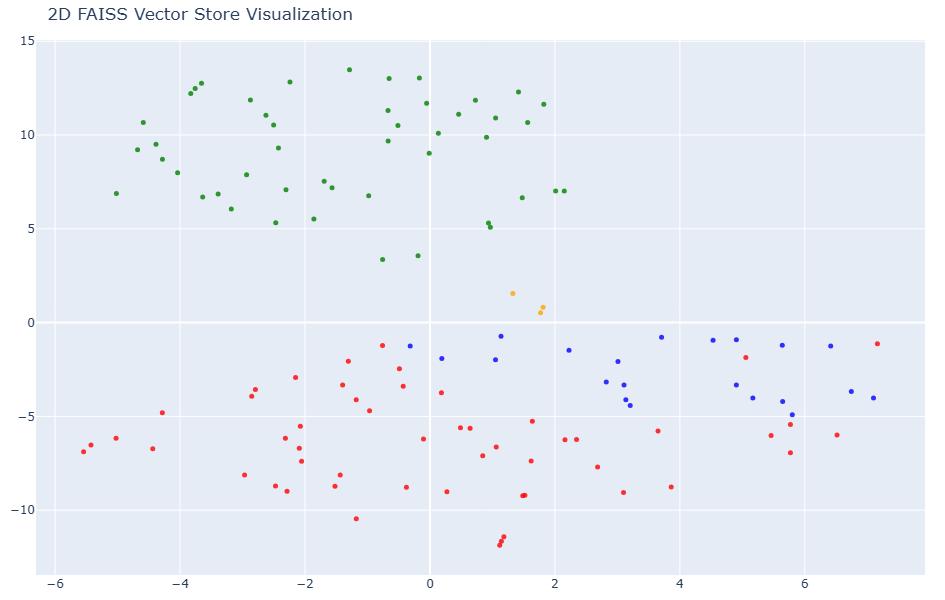

In [16]:
# 2d visual

tsne = TSNE(n_components=2, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='2D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x',yaxis_title='y'),
    width=800,
    height=600,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

In [17]:
# 3d
tsne = TSNE(n_components=3, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create the 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, color=colors, opacity=0.8),
    text=[f"Type: {t}<br>Text: {d[:100]}..." for t, d in zip(doc_types, documents)],
    hoverinfo='text'
)])

fig.update_layout(
    title='3D FAISS Vector Store Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y', zaxis_title='z'),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## LangChain

In [18]:
# create a new Chat with OpenAI
llm = ChatOpenAI(temperature=0.7, model_name=MODEL)

# set up the conversation memory for the chat
memory = ConversationBufferMemory(memory_key='chat_history', return_messages=True)

# the retriever is an abstraction over the VectorStore that will be used during RAG
retriever = vectorstore.as_retriever()

# putting it together: set up the conversation chain with the GPT 3.5 LLM, the vector store and memory
conversation_chain = ConversationalRetrievalChain.from_llm(llm=llm, retriever=retriever, memory=memory)

In [19]:
query = "Can you describe Insurellm in a few sentences"
result = conversation_chain.invoke({"question":query})
print(result["answer"])

Insurellm is an innovative insurance tech startup founded by Avery Lancaster in 2015, aimed at disrupting the insurance industry with its range of software products. The company, which has grown to 200 employees and operates 12 offices across the US by 2024, offers four main products: Carllm for auto insurance, Homellm for home insurance, Rellm for the reinsurance sector, and Marketllm, a marketplace connecting consumers with insurance providers. With over 300 clients worldwide, Insurellm focuses on delivering reliable and transformative solutions in the insurance market.


## Gradio using the Chat interface


In [20]:
# Wrapping that in a function

def chat(message, history):
    result = conversation_chain.invoke({"question": message})
    return result["answer"]

In [26]:
#view = gr.ChatInterface(chat).launch()
# 
gr.ChatInterface(fn=chat, type= "messages").launch()

* Running on local URL:  http://127.0.0.1:7895

To create a public link, set `share=True` in `launch()`.
